# **AMEBAS: Automatic Midline Extraction and Background Subtraction**

<a href="https://github.com/badain/amebas" target="_blank">
    <img
        width="800px"
        alt='Animated image showcasing AMEBaS logo and a ratiometric segmented cell timelapse'
        src='https://raw.githubusercontent.com/badain/amebas/main/amebas_banner.gif' />
</a>

## Demonstration with ratiometric fluorescence time lapses of polarized single cells
Current methods to analyze the intracellular dynamics of fluorescent reporters along the midline of polarized single cells often rely on manual tracing and arbitrary choices of background values, lacking standardization and automation. In this context, this manuscript introduces a novel bioinformatics pipeline to automate midline extraction of single polarized cells and quantify the spatiotemporal behavior from ratiometric (or single channel) time-lapses in a user-friendly interface that can be run fully online.

### AUTHORS AND AFFILIATIONS:
* Rafael Badain - Institute of Mathematics and Statistics, University of São Paulo, Brazil) - badain@usp.br
* Daniel S.C. Damineli - Institute of Mathematics and Statistics, University of São Paulo, Brazil) - danieldamineli@usp.br
* Maria Teresa Portes - Departamento de Botânica, Instituto de Biociências, University of São Paulo, Brazil - mtportes@usp.br
* José Feijó - Cell Biology and Molecular Genetics Department, University of Maryland, College Park, USA - jfeijo@umd.edu
* Hugo Neves de Oliveira - Institute of Mathematics and Statistics, University of São Paulo, Brazil) – oliveirahugo@ime.usp.br
* Roberto M. Cesar Jr - Institute of Mathematics and Statistics, University of São Paulo, Brazil) - rmcesar@usp.br

## SETUP
The cell below:

*   Setups the coding environment
*   Clones GitHub repo https://github.com/badain/amebas.git
*   Download sample data

In [ ]:
#@title Initial setup { display-mode: "form"}
!git clone https://github.com/badain/amebas.git
!mkdir amebas/data
!mkdir amebas/out

In [ ]:
cd amebas

In [ ]:
#@title Python libraries installation { display-mode: "form"}
!pip install mrc
!pip install skan
!pip install napari
!pip install PyQt5
!pip install skimage==0.19.3
!pip install loess
!pip install matplotlib==3.5.2

In [6]:
#@title Python Imports { display-mode: "form"}
# utilities
import time
import numpy as np
import shutil

# image processing
from mrc import imread # dv reader
from skan import Skeleton
from skimage import io, filters

# visualization
from matplotlib import pyplot as plt

# colaboratory
from google.colab import drive, files

# repository
from visualization import *
from processing import *

## FILE INPUT

In [4]:
#@title Run to upload the input timelapse { display-mode: "form"}
# 0 FILE UPLOAD
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

def upload_file():
    uploaded = files.upload()
    try:
        filename = list(uploaded.keys())[0]
    except:
        print ("Please upload a valid timelapse")
        raise StopExecution
    print(f'Uploaded "{filename}" with {len(uploaded[filename])} bytes')
    return filename

print("Upload timelapse:")
filename = upload_file()

Upload timelapse:


Saving Kymo_Ratio.dv to Kymo_Ratio.dv
Uploaded "Kymo_Ratio.dv" with 204128256 bytes


Kymo_Ratio.dv shape: (124, 2, 640, 640)


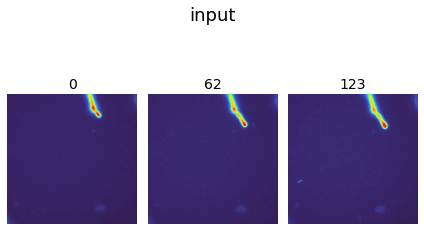

In [7]:
#@title Run to read the input timelapse and separate its channels { display-mode: "form"}
# 1 FILE READING
ts = time.time()
workDir = '/content/amebas'
verbose = True

# file reading
shutil.move(filename, f"{workDir}/data/{filename}")
if(".dv" in  filename):
  im = imread(f"{workDir}/data/{filename}")
elif(".tiff" in  filename):
  im = np.array(io.imread(f"{workDir}/data/{filename}"))
else:
  raise Exception('Filetype not recognized.')

# shape: num_images, channels, Y, X
print(filename, "shape:", im.shape)

# channel separation
if(im.ndim == 4):
    hasTwoChannels = True
elif(im.ndim == 3):
    hasTwoChannels = False
else:
    raise Exception('Invalid number of dimensions.')

if(hasTwoChannels):
    c_0 = im[:,0,:,:]
    c_1 = im[:,1,:,:]
else:
    c_1 = im

if(verbose): display(c_1, 'input', filename, '1', workDir, 'turbo')

## [1] SINGLE CELL SEGMENTATION
This step segments the cell from the background, producing a binary mask by a thresholding technique in the pixel intensity space. Background intensity is further estimated by polynomial regression

[2] main cell segmentation
[2.1] pre-processing filters


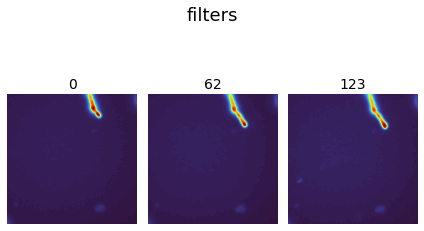

[2.2] isodata tresholding


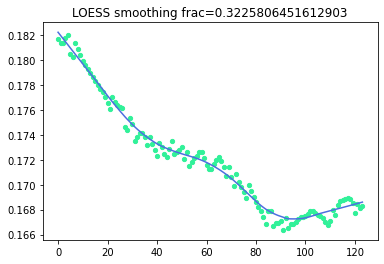

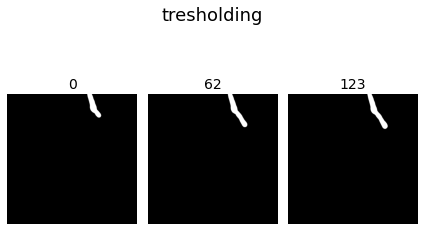

[2.3] isolating region with largest area


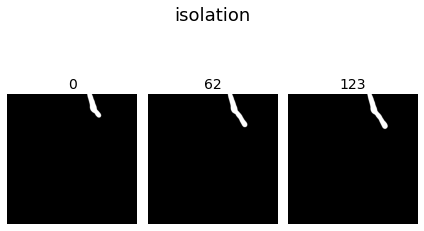

In [ ]:
#@title Run to detect the main cell and segment from background { display-mode: "form"}
# 2 DETECTING THE MAIN CELL
sigma = 2 # sigma used in pre-processing steps for thresholding
n_points = 40 # number of points used in loess smoothing of the background threshold values
estimate = True

print('[2] main cell segmentation')
print('[2.1] pre-processing filters')
if(hasTwoChannels): median_c_0 = filters.median(c_0)
median_c_1 = filters.median(c_1)
gaussian_c_1 = filters.gaussian(median_c_1, sigma=sigma)
if(verbose): display(gaussian_c_1, 'filters', filename, '2_1', workDir, 'turbo')
print('[2.2] isodata tresholding')
mask_c_1, thresh_c_1 = thresholding(gaussian_c_1, n_points, estimate, verbose, workDir, filename)
if(verbose): display(mask_c_1, 'tresholding', filename, '2_2', workDir, 'gray')

# isolating largest area
print('[2.3] isolating region with largest area')
mask_c_1, signal_c_1 = isolate_largest_area(mask_c_1)
if(verbose): display(mask_c_1, 'isolation', filename, '2_3', workDir, 'gray')
io.imsave(f'{workDir}/out/{filename}_binary_mask.tiff', mask_c_1) # exports binary mask timelapse

## [2] CELL MIDLINE TRACING
This step traces a path through the midline of the cell through skeletonization and extrapolates its path based on the cell's growth direction

[3.1] skeletonization


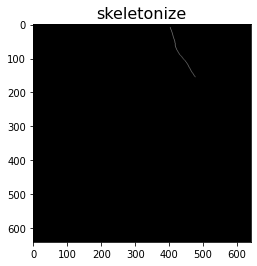

[3.2] skeleton extrapolation


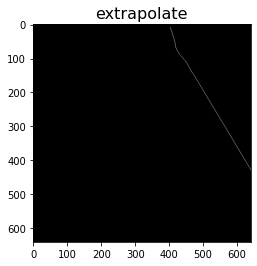

In [ ]:
#@title Run to trace the cell midline and extrapolate its path { display-mode: "form"}
# 3 SKELETONIZE
interpolation_fraction = .25
extrapolation_length = -1
last_frame = c_1.shape[0] - 1
complete_skeletonization = True

print("[3.1] skeletonization")
if(complete_skeletonization):
    skeleton_timelapse, skeleton_coordinates = skeletonize_all_frames(mask_c_1)    # skeletonizes all frames
    io.imsave(f'{workDir}/out/{filename}_skeletonized.tiff', skeleton_timelapse) # exports skeleton timelapse
    skeleton, skeleton_object = skeleton_timelapse[last_frame], skeleton_coordinates[last_frame]
    first_skeleton, first_skeleton_object = skeleton_timelapse[0], skeleton_coordinates[0]
else:
    skeleton, skeleton_object = skeletonization(mask_c_1[last_frame,:,:])
    first_skeleton, first_skeleton_object = skeletonization(mask_c_1[0,:,:])
    io.imsave(f'{workDir}/out/{filename}_skeletonized.tiff', skeleton) # exports skeleton

if(verbose): display_single(skeleton, 'skeletonize', filename, '3_1', workDir, 'gray')

angle, coordinates, growing_forward = get_growth_direction(first_skeleton_object, skeleton_object)
if(not complete_skeletonization):
    print("[3.2] skeleton extrapolation")
    if(interpolation_fraction > 0):
        if(interpolation_fraction >= 1): interpolation_size = coordinates.shape[0] - 1
        else: interpolation_size = coordinates.shape[0] * interpolation_fraction
        extrapolation = extrapolate(skeleton, int(interpolation_size), extrapolation_length, angle, coordinates)
        extended_skeleton = Skeleton(np.logical_or(skeleton, extrapolation)) # extrapolation + skeleton
        if(verbose): display_single(np.logical_or(skeleton, extrapolation), 'extrapolate', filename, '3_2', workDir, 'gray')
    else:
        extended_skeleton = skeleton_object

## [3] DATA VISUALIZATION
This step outputs kymographs of both channels and their ratio after background subtraction, smoothing, and outlier removal together with a stack of ratiometric images

[4] kymograph generation


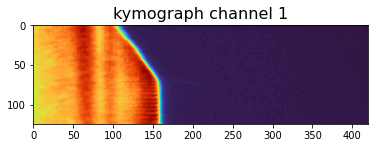

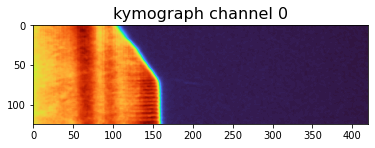

In [ ]:
#@title Run to generate Kymograph { display-mode: "form"}
kymograph_kernel = 3
shift_fraction = 0.5
shifted_turbo_cmap = generate_cmap(shift_fraction)

print("[4] kymograph generation")
if(not complete_skeletonization):
    kymograph_c_1 = kymograph(median_c_1, extended_skeleton.coordinates, kymograph_kernel, growing_forward)
    if(hasTwoChannels): kymograph_c_0 = kymograph(median_c_0, extended_skeleton.coordinates, kymograph_kernel, growing_forward)
else:
    kymograph_c_1 = kymograph_framewise(median_c_1, skeleton_coordinates, kymograph_kernel, growing_forward)
    if(hasTwoChannels): kymograph_c_0 = kymograph_framewise(median_c_0, skeleton_coordinates, kymograph_kernel, growing_forward)

# output
if(not complete_skeletonization): cmap = plt.cm.turbo
else: cmap = shifted_turbo_cmap

if(verbose): display_single(kymograph_c_1, 'kymograph channel 1', filename, '4', workDir, 'turbo')
plt.imsave(f'{workDir}/out/{filename}_kymograph_c_1.png', kymograph_c_1, cmap=cmap)
np.savetxt(f"{workDir}/out/{filename}_kymograph_c_1.csv", kymograph_c_1, delimiter=",")
if(hasTwoChannels):
    if(verbose): display_single(kymograph_c_0, 'kymograph channel 0', filename, '4', workDir, 'turbo')
    plt.imsave(f'{workDir}/out/{filename}_kymograph_c_0.png', kymograph_c_0, cmap=cmap)
    np.savetxt(f"{workDir}/out/{filename}_kymograph_c_0.csv", kymograph_c_0, delimiter=",")

[5] ratiometric results


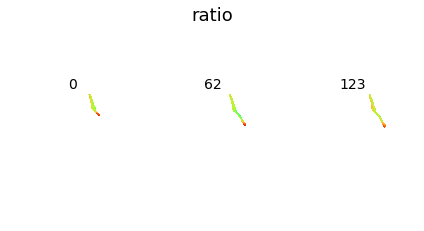

In [ ]:
#@title Run to generate the Ratiometric Timelapse { display-mode: "form"}
smooth_ratio = False
switch_ratio = False
background_ratio = False
reject_outliers = True
kymograph_kernel = 3
shift_fraction = 0.7

print("[5] ratiometric results")
if(hasTwoChannels):
    ratio, masked_ratio = ratiometric(median_c_0, median_c_1, signal_c_1, mask_c_1, thresh_c_1, smooth_ratio, reject_outliers, switch_ratio)
    if(verbose): display_three(masked_ratio, "ratio", filename, '5_1', workDir, 'turbo')
    io.imsave(f'{workDir}/out/{filename}_ratiometric.tiff', ratio)
    if(background_ratio): io.imsave(f'{filename}_ratiometric.tiff', ratio)
    else: io.imsave(f'{filename}_ratiometric.tiff', masked_foreground(ratio, mask_c_1))

    if(not complete_skeletonization): kymograph_ratio = kymograph(masked_foreground(ratio, mask_c_1), skeleton_object.coordinates, kymograph_kernel, growing_forward)
    else: kymograph_ratio = kymograph_framewise(masked_foreground(ratio, mask_c_1), skeleton_coordinates, kymograph_kernel, growing_forward)

    shifted_turbo_cmap = generate_cmap(shift_fraction)
    plt.imsave(f'{filename}_kymograph_ratio.png', kymograph_ratio, cmap=shifted_turbo_cmap)
    np.savetxt(f"{workDir}/out/{filename}_kymograph_ratio.csv", kymograph_ratio, delimiter=",")